In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene

In [2]:
# Works for MODIS and S3 .L2.OC.x.nc files #
#  Test for MERIS
files = glob('/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.*.L2.OC.x.nc')
files.sort()
files


['/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100101T190501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100102T195001.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100103T185501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100104T193501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100104T194001.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100105T184000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100105T184500.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100105T202000.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100106T192501.L2.OC.x.nc',
 '/home/hboi-ouri/Projects/RS_Files/MODIS2010-2012/JAN2010/AQUA_MODIS.20100107T183001.L2.OC.x.nc',
 '/home/hb

# OPENING FILES, PUTING THEM IN A COMMON GRID, AND SAVING A COMBINED FILE

In [3]:
# Functions to be used

def convtoxr(scn, var):
    #convert from dask array
    data = scn[var].load()
    data = data.where(data >= 0)
    data.name = var
    del(data.attrs['_satpy_id']) ### removing, we don't need this.
    data.attrs['area'] = str(data.attrs['area']) ### We may or may not need this in the future so converting it to a string
    return data

def load_satdata(path, 
                 area_deff=None,
                 res=None,
                 name="GOMEX", proj={"proj": "laea"}, area_extent=(-91, 28, -88, 31),
                ):
#   get data and attributes
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    attrs = xr.open_dataset(path).attrs
    
#   area definition if not defined
    if res is None:
        # get the resolution of the Sat product
        val, unit = attrs['spatialResolution'].split()
        res  = xr.DataArray(float(val), attrs={"units": unit})
    if area_deff is None:
        area_deff = create_area_def(name, proj, area_extent=area_extent, units="degrees", resolution=res)
        
#   reprojecting
    scn = Scene()
    swath_def = geometry.SwathDefinition(lons=navigation.longitude, lats= navigation.latitude)
    vnames = [v for v in data.data_vars if 'Rrs' in v]
    for var in vnames:
        scn[var] = data[var]
        scn[var].attrs["area"] = swath_def
    resampled_scn = scn.resample(area_deff, radius_of_influence=int(res))
    resampled_scn.compute()
    lons, lats = resampled_scn[vnames[0]].attrs['area'].get_lonlats()
#   Converting back to xarray dataset
    ds = xr.merge([convtoxr(resampled_scn, var) for var in vnames])
    ds.attrs = attrs
    ds = ds.assign_coords({
                            'lon': (('y', 'x'), lons),
                            'lat': (('y', 'x'), lats),
                            'time': pd.to_datetime(attrs['time_coverage_start'])
                            })
#   getting rid of the crs coord
    # ds.attrs['crs'] = ds.crs
    ds = ds.drop('crs')
    print(str(ds.time.data))
    return ds


In [4]:
# Area setup for GOMEX
resval = 300 # resolution of the sat product (300 m for Sentinel and MERIS, 1 km for MODIS)
extent = (-91, 28, -88, 31)
res = xr.DataArray(resval, attrs={"units": "meters"})
lat_0, lon_0 = 28.5, -90.8 # just some rounded up mean from the lat lon range of the sat product
proj = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'} # projection object
area = create_area_def("GOMEX", proj,
                       area_extent=extent, units="degrees", 
                       resolution=res
                      ) # creating a fixed area to reproject to



Rounding shape to (1123, 956) and resolution from (300.0, 300.0) meters to (299.72703443568895, 299.85149942752383) meters


In [ ]:
# Reprojectig files
dsets = [load_satdata(f, area_deff=area, res=res) for f in files] # looping trough the files
print('0')
#combined = xr.concat(dsets, dim='time') #combining in one file
combined = xr.concat(dsets[:20], dim='time')
print('00')


#for naming the file
date = [f.split('.')[1] for f in files]
year = ((date[1])[0:4])
month = ((date[1])[4:6])


#save combined file
# give a sensible name i.e. cruiseID_satID.nc for every cruise and satelite
combined.to_netcdf('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010' + year + '_' + month + '_MODIS_L2.nc') 


    
    

/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-01T19:05:01.644000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-02T19:50:01.072000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-03T18:55:01.946000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-04T19:35:01.521000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-04T19:40:01.375000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-05T18:40:00.921000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-05T18:45:00.775000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-05T20:20:00.952000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-06T19:25:01.827000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-07T18:30:01.226000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-07T20:10:01.258000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-08T19:10:00.802000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-08T19:15:00.656000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-09T18:20:01.526000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-09T19:55:01.702000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-10T19:00:01.097000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-11T19:45:00.521000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-12T18:50:01.393000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-13T19:30:00.969000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-14T18:35:01.846000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-14T20:15:01.879000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-15T19:20:01.283000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-16T18:25:00.682000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-16T20:00:00.859000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-16T20:05:00.713000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-17T19:05:01.734000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-18T19:50:01.163000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-19T18:55:00.562000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-20T19:35:01.615000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-20T19:40:01.469000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-21T18:40:01.012000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-21T18:45:00.865000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-21T20:20:01.043000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-22T19:25:01.917000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-23T18:30:01.314000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-23T20:10:01.345000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-24T19:10:00.888000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-24T19:15:00.742000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-25T18:20:01.615000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-25T19:55:01.793000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-26T19:00:01.186000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-27T19:45:00.609000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-28T18:50:01.480000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-29T19:30:01.051000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-30T18:35:01.922000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-30T20:15:01.953000000


/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinat

2010-01-31T19:20:01.348000000
0


In [ ]:
ds2 = combined.chunk({'y':10, 'x':2, 'time':1})

# PLOTTING

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

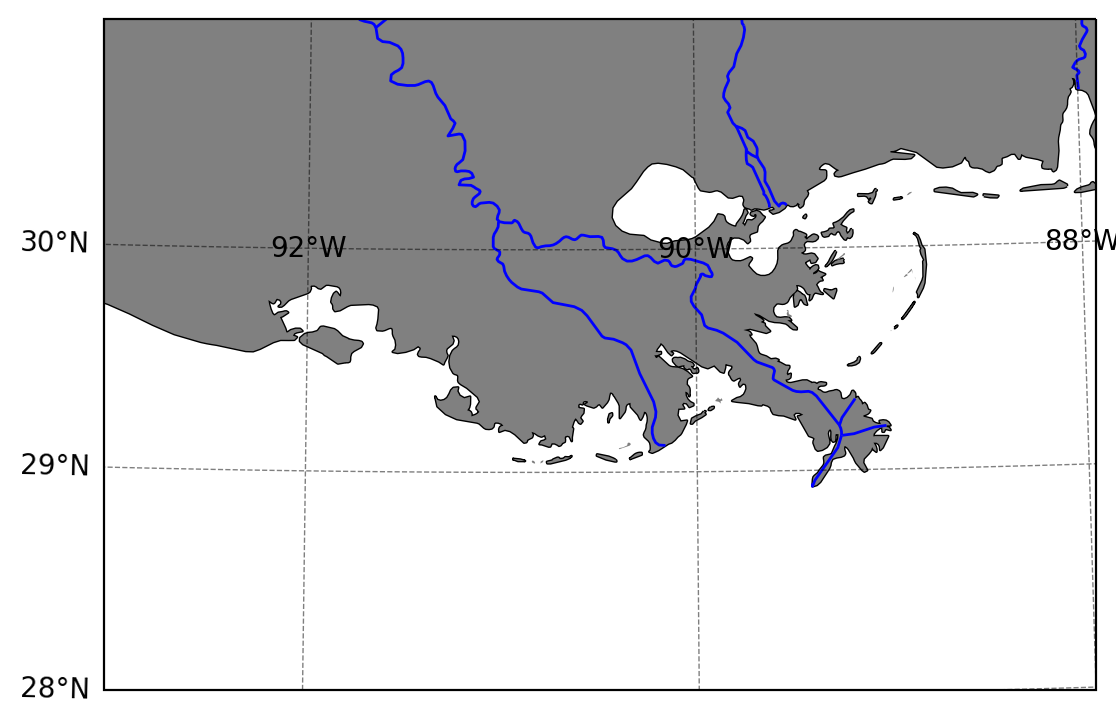

In [6]:
# Map base function
lat_0, lon_0 = 28.5, -90.8

lat_top=31
lat_bot=28
lon_left=-88
lon_rigth=-93
extent=[lon_left, lon_rigth, lat_bot, lat_top]

def plot_mapbase(extent=extent, res='10m', projection=ccrs.PlateCarree(), ax=None):
    if ax is None:
        fig = plt.figure(dpi=200) # set fig size
        ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent , crs=ccrs.PlateCarree())
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))

    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                 ylocs=[28, 29,30], 
                 xlocs=[-94, -92, -90, -88], 
                 draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')
    gl.right_labels = False
    return ax

ax = plot_mapbase(projection= ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0))

In [7]:
def get_CDOM(ds, lambd=300):
    '''
    ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                        + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                        + epsilon * ln(Rrs667) + zeta
    a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
    '''
    
    ds=ds.where(ds>0)
    
    if lambd==300:
        alpha = -.0206
        beta = -.6128
        gamma = -.007
        delta = -.4944
        epsilon = .9362
        zeta = .9666
        
    elif lambd==355:
        alpha = .0376
        beta = -.8714
        gamma = -.0352
        delta = -.2739
        epsilon = .9591
        zeta = -.1071
    else:
        print('alg not defined gor lambda={}'.format(lamdb))
        return
        
        
    aCDOM = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                  beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                  gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                  delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                  epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)
    
    #alpha0 = -.0537
    #beta0 = -.2689
    #gamma0 = .1017
    #delta0 = -.2097
    #epsilon0 = -.0893
    #zeta0 = -3.6853
    
    #S_275_295 = np.exp(alpha0 * np.log(ds.Rrs_443) +
                  #beta0 * np.log(ds.Rrs_488) +
                  #gamma0 * np.log(ds.Rrs_531) +
                  #delta0 * np.log(ds.Rrs_555) +
                  #epsilon0 * np.log(ds.Rrs_667) + zeta0)
    
   # aCDOM_star = np.exp(-15.05 - 33.95 * S_275_295) + np.exp(-1.502 - 104.3 * S_275_295)
                  
   # DOC = aCDOM/aCDOM_star
                  
    #print('Returning aCDOM(lambda), SS_275_295 and DOC for lambda ' + str(lambd))
    #print('aCDOM({}): CDOM absorption spectra (m-1)'.format(lambd))
    #print('SS_275_295: CDOM absorption spectral slope coefficient in the 275–295 nm spectral region (nm-1)')
    #print('DOC: Disolved organic carbon (umol L-1)')
    #print('according to Cao et. al 2018')
    return aCDOM

In [5]:
combfiles = glob('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/*MODIS_L2.nc')
combfiles.sort()
combfiles

['/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_07_MODIS_L2.nc',
 '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_08_MODIS_L2.nc',
 '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_09_MODIS_L2.nc',
 '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_10_MODIS_L2.nc',
 '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_11_MODIS_L2.nc']

In [6]:
##for testing data set
year, month = '2010', '11'
cfile = '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/' + year + '/' + year + '_' + month +'_MODIS_L2.nc'
ds = xr.open_dataset(cfile)

#for var in ds.data_vars:
    #print(var)
    #ds[var] = ds[var].where(ds[var]>=0)

#ds = ds.where(ds.apply(np.isfinite))
#ds = ds.where(ds>=0)

ds['acdom']=get_CDOM(ds)

#combined.where(combined >=0)


/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010/2010_11_MODIS_L2.nc


In [25]:
ds

<xarray.Dataset>
Dimensions:  (time: 49, y: 1123, x: 956)
Coordinates:
  * y        (y) float64 2.81e+05 2.807e+05 2.804e+05 ... -5.513e+04 -5.543e+04
  * x        (x) float64 -1.949e+04 -1.919e+04 ... 2.665e+05 2.668e+05
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * time     (time) datetime64[ns] 2010-11-21T18:40:00.522000 ... 2010-11-26T...
Data variables:
    Rrs_412  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_443  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_469  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_488  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_531  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_547  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_555  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_645  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_667  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Rrs_678  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    acdom    (time, y, x) float32 nan nan nan nan nan ... 0.6744 nan nan nan nan
Attributes: (12/48)
    title:                          MODISA Level-2 Data
    product_name:                   AQUA_MODIS.20101121T184000.L2.OC.nc
    processing_version:             R2022.0
    equatorCrossingLongitude:       93.00351
    orbit_number:                   45487
    history:                        l2gen par=/data14/sdpsoper/vdc/vpu33/work...
    ...                             ...
    geospatial_lon_max:             -85.98936
    geospatial_lon_min:             -94.18107
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  1.0248523950576782

In [ ]:
acdom = get_CDOM(ds)
acdom.count(dim='time').plot(vmin=0, vmax=5)
acdom.plot()

In [ ]:
# Looping through times to plot:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

#Need to define GOOD min and max values for colorbar so it is the same for all figures
vmin = 0
# vmax = combined.Rrs_443.max()*10e2 #should probably set to a fix number so all different periods have the same color range
vmax = 5 # FIND A SENSIBLE VALUE FOR VMAX

# arguments for the colorbar
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':30, 'label':'Rrs 443 nm (x 10$^{-2}$ sr$^{-1}$)', 'pad': .01}
# Map projection
map_proj = ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0)

# looping through time dim
for i in range(combined.time.size):
    fig = plt.figure(dpi=200) # set fig size
    ax = fig.add_subplot(111, projection=map_proj)
    plot_mapbase(ax=ax)
    #data = combined.aCDOM.isel(time=i) # <<<<< CHANGE THIS FOR PLOTING OTHER VARIABLES
    data = acdom.isel(time=i)
    label = '/home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_{}_.png'.format(str(data.time.values)[:10]) # <<<<< CHANGE NAME IN LABEL 
    print(i, label)
    sat = (10e2*data.where(data>0)).plot(x='lon', y='lat',
                         transform=ccrs.PlateCarree(),
                         cmap='pink_r', vmin=vmin, vmax=vmax,
                         cbar_kwargs=cbar_kwargs,
                         robust=False,
                         ax=ax
                        )
    

    fig.savefig(label)
    plt.close(fig)

In [ ]:
year, month = '2010', '11'
cfile = '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/' + year + '_' + month + '_MODIS_L2.nc'

ds = xr.open_dataset('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010_07_MODIS_L2.nc')
ds2 = xr.open_dataset('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010_08_MODIS_L2.nc')

ds['acdom']=get_CDOM(ds)
ds2['acdom']=get_CDOM(ds2)

acdom = get_CDOM(ds)
acdom2 = get_CDOM(ds2)

fig, axes = plt.subplots(ncols=1, nrows=3)
acdom.count('time').plot(ax=axes[0])
acdom2.count('time').plot(ax=axes[1])




line0
line1
line0


In [47]:
# Looping through times to plot grid:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

#Need to define GOOD min and max values for colorbar so it is the same for all figures
vmin = 0
# vmax = combined.Rrs_443.max()*10e2 #should probably set to a fix number so all different periods have the same color range
vmax = 5 # FIND A SENSIBLE VALUE FOR VMAX

# arguments for the colorbar
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':30, 'label':'Rrs 443 nm (x 10$^{-2}$ sr$^{-1}$)', 'pad': .01}
# Map projection
map_proj = ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0)

# looping through time dim
for i in range(ds.time.size):
    fig = plt.figure(dpi=200) # set fig size
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 4),
                    axes_pad=0.6,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode
    for i, ax in enumerate(axgr):
        ax.set_xticks(np.linspace(-180, 180, 5), crs=map_proj)
        ax.set_yticks(np.linspace(-90, 90, 5), crs=map_proj)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)


    plot_mapbase(ax=ax)
    #data = combined.aCDOM.isel(time=i) # <<<<< CHANGE THIS FOR PLOTING OTHER VARIABLES
    data = acdom.isel(time=i)
    label = '/home/hboi-ouri/Projects/NASA_Project/outputs/CombinedNC/MODISFigures/MODIS_aCDOM_{}_.png'.format(str(data.time.values)[:10]) # <<<<< CHANGE NAME IN LABEL 
    print(i, label)
    sat = (10e2*data.where(data>0)).plot(x='lon', y='lat',
                         transform=ccrs.PlateCarree(),
                         cmap='Blues', vmin=vmin, vmax=vmax,
                         cbar_kwargs=cbar_kwargs,
                         robust=False,
                         ax=ax
                        )
    
    axgr.cbar_axes[0].colorbar(p)

    plt.show()
    

    fig.savefig(label)
    plt.close(fig)

NameError: name 'axes_class' is not defined

<Figure size 1280x960 with 0 Axes>

In [1]:
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.pyplot as plt
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np
from pyresample import geometry, create_area_def
from satpy import Scene
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
def get_CDOM(ds, lambd=300):
    '''
    ln(a_CDOM(lambda)) = alpha * ln(Rrs443) + beta * ln(Rrs448)
                        + gamma * ln(Rrs531) + delta * ln(Rrs(555))
                        + epsilon * ln(Rrs667) + zeta
    a_CDOM(300) = (exp(-15.05 - 33.95 * S_275-295)) + exp(-1.502 - 104.3 * S_275-295)
    '''
    for var in ds.data_vars:
        ds[var] = ds[var].where(ds[var]>=0)
    if lambd==300:
        alpha = -.0206
        beta = -.6128
        gamma = -.007
        delta = -.4944
        epsilon = .9362
        zeta = .9666
        
    elif lambd==355:
        alpha = .0376
        beta = -.8714
        gamma = -.0352
        delta = -.2739
        epsilon = .9591
        zeta = -.1071
    else:
        print('alg not defined gor lambda={}'.format(lamdb))
        return
        
    aCDOM = np.exp(alpha * np.log(ds.Rrs_443.where(ds.Rrs_443>=0)) +
                  beta * np.log(ds.Rrs_488.where(ds.Rrs_488>=0)) +
                  gamma * np.log(ds.Rrs_531.where(ds.Rrs_531>=0)) +
                  delta * np.log(ds.Rrs_555.where(ds.Rrs_555>=0)) +
                  epsilon * np.log(ds.Rrs_667.where(ds.Rrs_667>=0)) + zeta)
    return aCDOM


In [ ]:
year= '2010'
cfile = glob('/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/' + year + '/*MODIS_L2.nc')
cfile.sort()

lat_top=31
lat_bot=28
lon_left=-88
lon_rigth=-93
extent=[lon_left, lon_rigth, lat_bot, lat_top]

projection = ccrs.PlateCarree()
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(dpi=200) # set fig size

axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 2),
                    axes_pad=0.1,
                    #share_all=True,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.4,
                    cbar_size='3%',
                    label_mode=''
               )

#fig2 = plt.figure(dpi=200) # set fig size

# axgr2 = AxesGrid(fig2, 111, axes_class=axes_class,
#                     nrows_ncols=(3, 2),
#                     axes_pad=0.1,
#                     #share_all=True,
#                     cbar_location='right',
#                     cbar_mode='single',
#                     cbar_pad=0.4,
#                     cbar_size='3%',
#                     label_mode=''
#                 )

for i, ax in enumerate(axgr):
    axgr[i].coastlines()
    #axgr[i].set_extent(extent)
    #axgr2[i].coastlines()
    #axgr2[i].set_extent(extent)
    try:
        ds = xr.open_dataset(cfile[i])
        acdom = get_CDOM(ds)
        data = acdom.count('time')
        #im = axgr[i].imshow(data, extent=extent, vmin=0, vmax=5)
        im = data.where(data!=0).plot(ax=axgr[i], vmin=0, vmax=5, add_colorbar=False, transform=projection)
        #im2 = acdom.mean('time').plot(ax=axgr2[i], vmin=0, vmax=6, add_colorbar=False, transform=projection)
    except:
        pass
    
    
    
axgr.cbar_axes[0].colorbar(im)
#axgr2.cbar_axes[0].colorbar(im2)

plt.show()
    

/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/hboi-ouri/miniconda3/envs/Satpy/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [1]:
acdom


NameError: name 'acdom' is not defined

In [ ]:
axgr = AxesGrid(fig, 111,
                    nrows_ncols=(3, 4),
                    axes_pad=0.1,
                    share_all=True,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='L')

for f, ax in zip(cfile, axgr.flatten()):
    ds = xr.open_dataset(f)
    acdom = get_CDOM(ds)
    data = acdom.count('time')
    im = axgr[cfile.index(f)].imshow(data, extent=extent, vmin=0, vmax=5)
    
axgr.cbar_axes[0].colorbar(im)

plt.show()

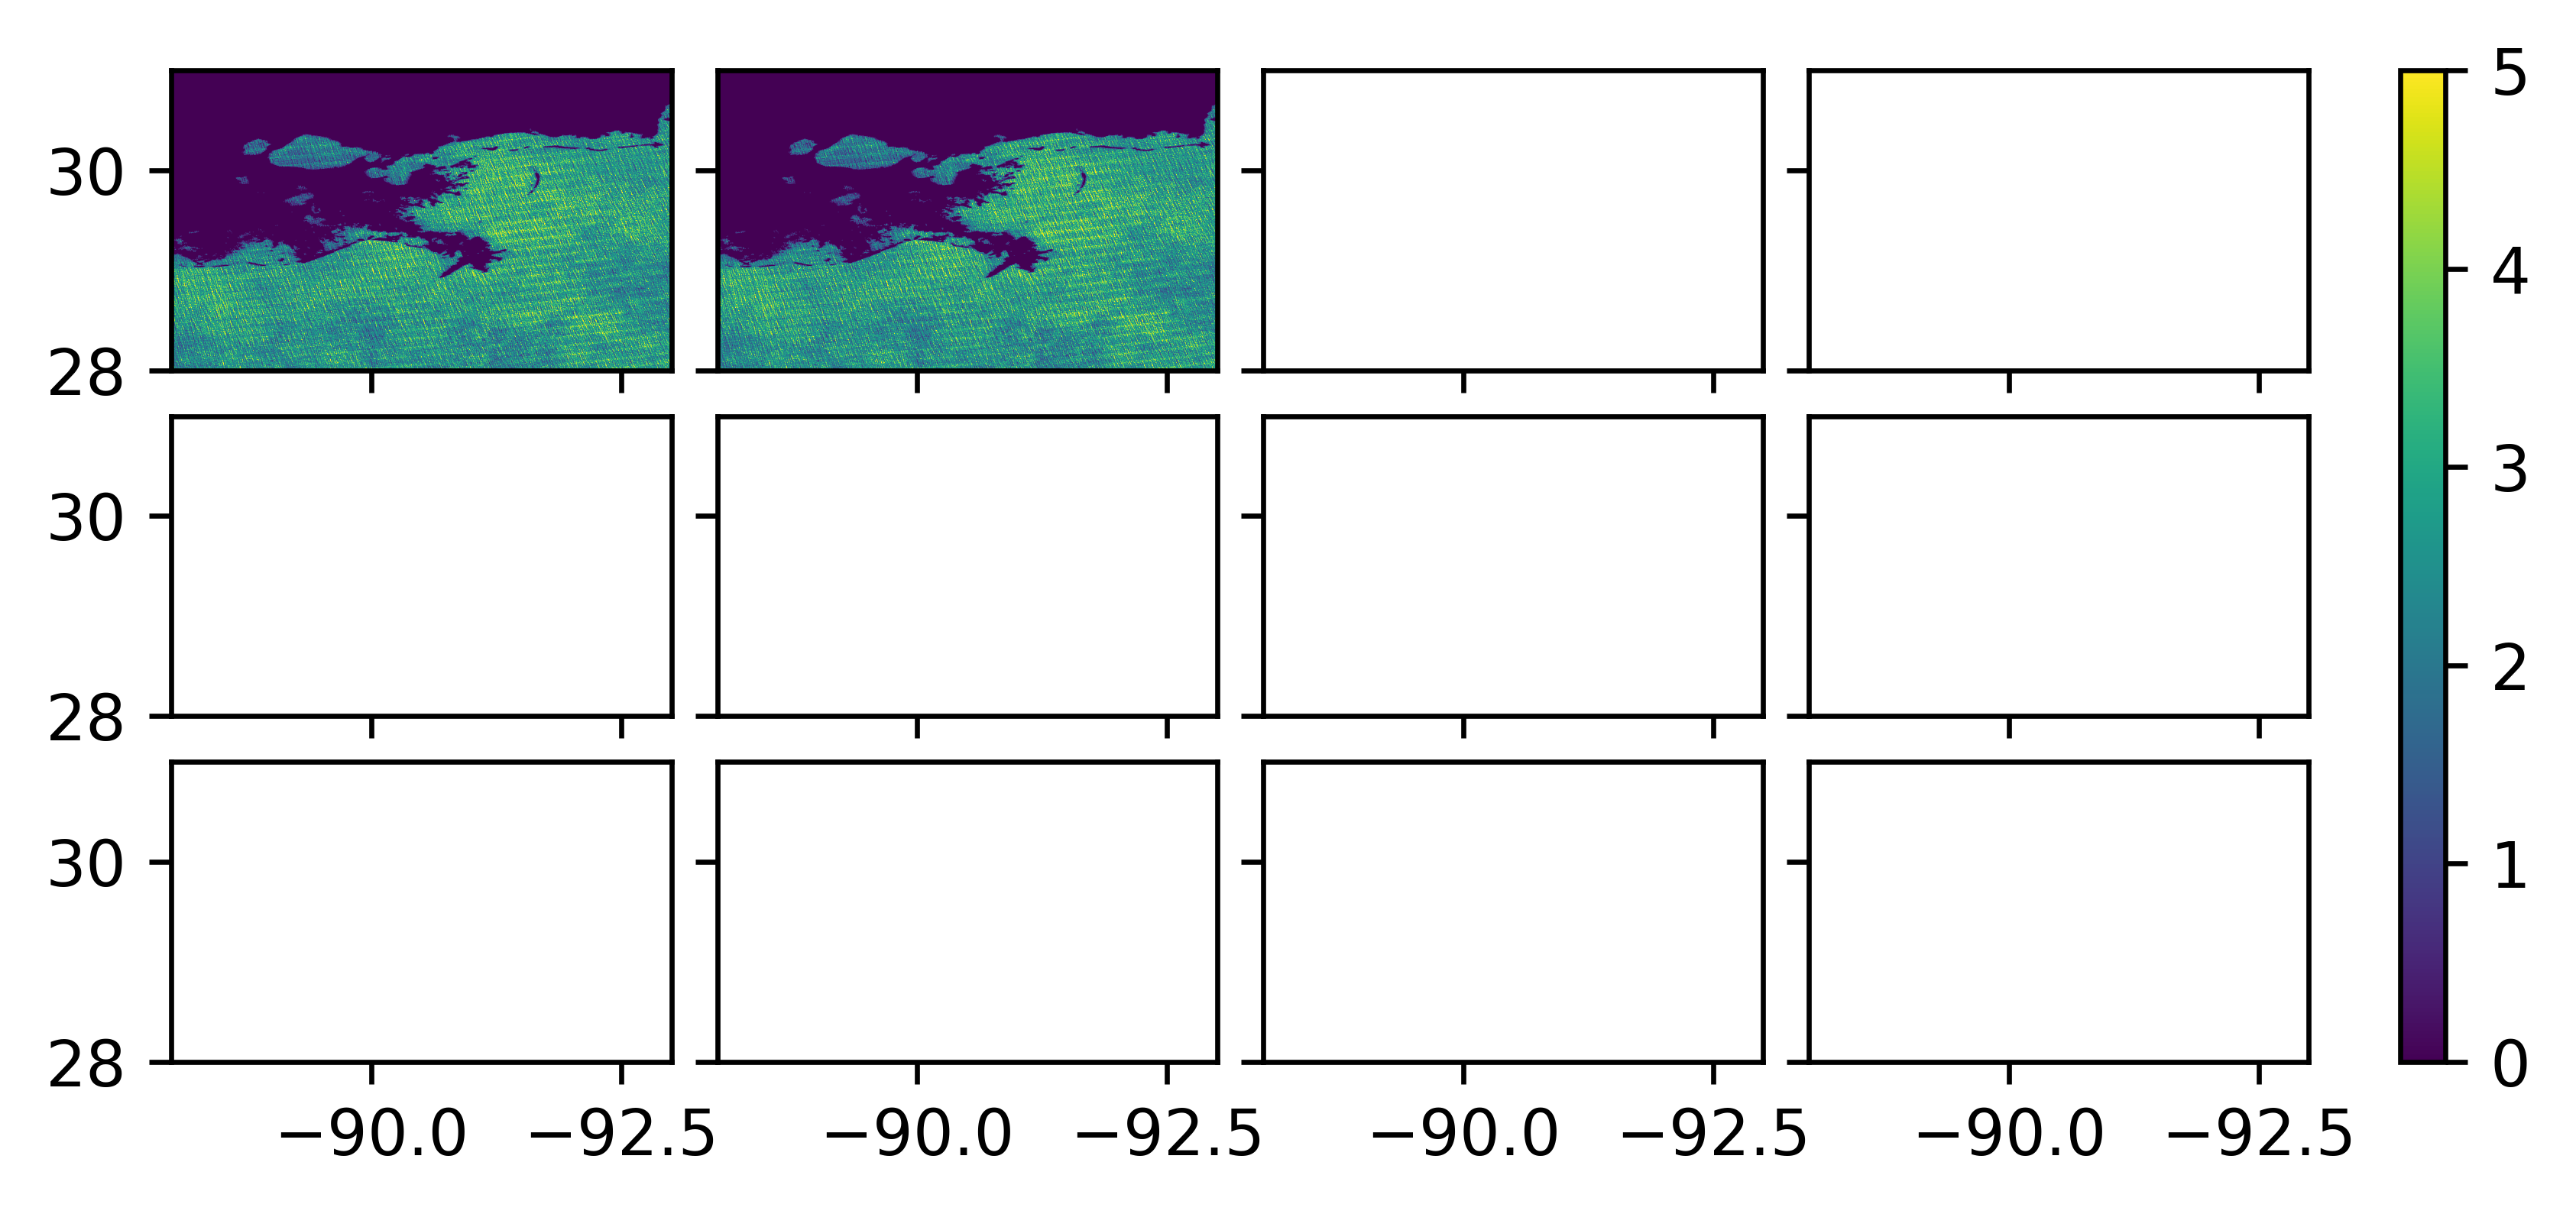

In [25]:
cfile = '/home/hboi-ouri/Projects/NASA_ProjectExp/outputs/CombinedNC/MODIS/2010_11_MODIS_L2.nc'

lat_top=31
lat_bot=28
lon_left=-88
lon_rigth=-93
extent=[lon_left, lon_rigth, lat_bot, lat_top]

fig = plt.figure(dpi=600)
axgr = AxesGrid(fig, 111,
                    nrows_ncols=(3, 4),
                    axes_pad=0.1,
                    share_all=True,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='L')

for f in range(2):
    ds = xr.open_dataset(cfile)
    acdom = get_CDOM(ds)
    data = acdom.count('time')
    im = axgr[f].imshow(data, extent=extent, vmin=0, vmax=5)
    
axgr.cbar_axes[0].colorbar(im)

plt.show()